In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from scipy import stats

from scipy.stats import poisson, norm, invgamma, uniform

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import warnings
warnings.filterwarnings('ignore')

In [37]:
J = 6

np.random.seed(111)
N = poisson.rvs(3, size=J, loc=10)

MU  = -9
TAU = 1
GAMMA = 2
ZETA = 3
RHO = 3
NU  = 4

np.random.seed(111)
ALPHA  = norm.rvs(size=J, loc=MU, scale=TAU)
BETA   = norm.rvs(size=J, loc=GAMMA, scale=ZETA)
SIGMA2 = invgamma.rvs(size=J, a=NU/2, scale=NU/2*RHO**2)

SIGMA = np.sqrt(SIGMA2)

VARIABLE = 'Y'
PREDICTOR = 'X'

ALPHA_LEVEL = 0.05
COMPARE_METRIC = 'waic' # metric for comparing the models, options are 'waic' or 'loo'

In [3]:
def Gauss2d(mu, cov, ci, ax=None):
    """Copied from statsmodel"""
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    v_, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees

    for level in ci:
        v = 2 * np.sqrt(v_ * stats.chi2.ppf(level, 2))  # get size corresponding to level
        ell = Ellipse(
            mu[:2],
            v[0],
            v[1],
            180 + angle,
            facecolor="None",
            edgecolor="k",
            alpha=(1 - level) * 0.5,
            lw=1.5,
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

    return ax

Create the data

In [4]:
np.random.seed(111)
X = uniform.rvs(size=N[0])
Y = norm.rvs(size=N[0], loc=ALPHA[0] + BETA[0] * (X-np.mean(X)), scale=SIGMA[0])
Dat = pd.DataFrame(np.array([Y, X, [0]*N[0]]).T)

for j in range(1,J):
    X = uniform.rvs(size=N[j])
    Y = norm.rvs(size=N[j], loc=ALPHA[j] + BETA[j] * (X-np.mean(X)), scale=SIGMA[j])
    DatAux = pd.DataFrame(np.array([Y, X, [j]*N[j]]).T)
    Dat = pd.concat([Dat, DatAux])

Dat = Dat.rename(columns={0:VARIABLE, 1:PREDICTOR, 2:'Region'})
Dat['Region'] = Dat['Region'].astype(int)

In [5]:
Dat = Dat[[VARIABLE, PREDICTOR, 'Region']]

In [6]:
PredictorMean = Dat[PREDICTOR].mean()

---

In [7]:
DatRegion = Dat[[PREDICTOR, 'Region']].groupby(['Region']).mean().reset_index()
DatRegion = DatRegion.rename(columns={PREDICTOR: PREDICTOR + 'Region'})

Dat = pd.merge(Dat, DatRegion)

Calculate the statistics per region

In [8]:
DatRegion = Dat[[VARIABLE, 'Region']].groupby(['Region']).agg(['mean', 'std']).reset_index()

DatRegion.columns = DatRegion.columns.droplevel()

DatRegion = DatRegion.rename(
    columns={
        '': 'Region'
        , 'mean': VARIABLE + 'Mean'
        , 'std': VARIABLE + 'Std'
    }
)

---

Estimate $\nu$ for all the data

In [9]:
ES2 = (DatRegion[VARIABLE + 'Std']**2).mean()
VS2 = (DatRegion[VARIABLE + 'Std']**2).var()

HatNu = 2 * ES2**2 / VS2 + 4

---

Regression model with common $\alpha$ and $\beta$

In [10]:
with pm.Model() as ModelCommonAlphaCommonBeta:
    Alpha = pm.Flat('Alpha')
    Beta  = pm.Flat('Beta')

    Sigma = pm.HalfFlat('Sigma')
    pm.Potential('p(Sigma)', 1/Sigma)

    MeanIncome = pm.Deterministic('MeanIncome', Alpha + Beta * (Dat[PREDICTOR] - PredictorMean))

    Income = pm.Normal('Income', mu=MeanIncome, sigma=Sigma, observed=Dat[VARIABLE])

Regression model with separate $\alpha$'s and $\beta$'s

In [11]:
with pm.Model() as ModelSeparateAlphaSeparateBeta:
    Alpha = pm.Flat('Alpha', shape=J)
    Beta  = pm.Flat('Beta', shape=J)

    Sigma = pm.HalfFlat('Sigma', shape=J)
    pm.Potential('p(Sigma)', 1/Sigma)

    MeanIncome = pm.Deterministic(
        'MeanIncome'
        , Alpha[Dat['Region']] + Beta[Dat['Region']] * (Dat[PREDICTOR] - Dat[PREDICTOR + 'Region']))

    Income = pm.Normal('Income', mu=MeanIncome, sigma=Sigma[Dat['Region']], observed=Dat[VARIABLE])

---

In [12]:
TraceCommonAlphaCommonBeta = pm.sample(model = ModelCommonAlphaCommonBeta)
TraceSeparateAlphaSeparateBeta = pm.sample(model = ModelSeparateAlphaSeparateBeta)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [13]:
HatMeanMu = TraceCommonAlphaCommonBeta.posterior.Alpha.values.mean()
HatStdMu  = TraceCommonAlphaCommonBeta.posterior.Alpha.values.std()

HatMeanTau = float(TraceSeparateAlphaSeparateBeta.posterior.Alpha.mean(('chain', 'draw')).std().values)

HatMeanGamma = TraceCommonAlphaCommonBeta.posterior.Beta.values.mean()
HatStdGamma  = TraceCommonAlphaCommonBeta.posterior.Beta.values.std()

HatMeanZeta = float(TraceSeparateAlphaSeparateBeta.posterior.Beta.mean(('chain', 'draw')).std().values)

---

Regression model with hierarchical structure for $\alpha$ and common $\beta$

In [14]:
with pm.Model() as ModelVaryingAlphaCommonBeta:

    Tau   = pm.Exponential('Tau', lam=1/HatMeanTau)
    Mu    = pm.Normal('Mu', mu=HatMeanMu, sigma=HatStdMu) # National average income
    Alpha = pm.Normal('Alpha', mu=Mu, sigma=Tau, shape=J) # Regional average income

    Beta = pm.Normal('Beta', mu=HatMeanGamma, sigma=HatStdGamma)

    Rho = pm.HalfFlat('Rho')
    pm.Potential('p(Rho)', -pm.math.log(Rho))

    Nu = pm.Exponential('Nu', lam=1/HatNu)

    Sigma2 = pm.InverseGamma('Sigma2', alpha=Nu/2, beta=Nu/2 * Rho**2, shape=J)
    Sigma  = pm.Deterministic('Sigma', pm.math.sqrt(Sigma2))

    MeanIncome = pm.Deterministic(
        'MeanIncome'
        , Alpha[Dat['Region']] + Beta * (Dat[PREDICTOR] - Dat[PREDICTOR + 'Region']))

    Income = pm.Normal(
        'Income'
        , mu = MeanIncome
        , sigma = Sigma[Dat['Region']]
        , observed = Dat[VARIABLE]
    )

In [15]:
with ModelVaryingAlphaCommonBeta:
    TraceVaryingAlphaCommonBeta = pm.sample()
    TraceVaryingAlphaCommonBeta.extend(pm.sample_posterior_predictive(TraceVaryingAlphaCommonBeta))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Tau, Mu, Alpha, Beta, Rho, Nu, Sigma2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 366 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [Income]


Regression model with hierarchical structure on $\alpha$ and $\beta$

In [16]:
with pm.Model() as ModelVaryingAlphaVaryingBeta:

    Chol, RhoAlphaBeta, CovAlphaBeta = pm.LKJCholeskyCov(
        "chol_cov"
        , n=2
        , eta=2
        , sd_dist=pm.Exponential.dist(lam=[1/HatMeanTau, 1/HatMeanZeta])
        , compute_corr=True
    )

    Mu    = pm.Normal('Mu', mu=HatMeanMu, sigma=HatStdMu)
    Gamma = pm.Normal('Gamma', mu=HatMeanGamma, sigma=HatStdGamma)

    AlphaBeta = pm.MvNormal("AlphaBeta", mu=[Mu, Gamma], chol=Chol, shape=(J, 2))

    Rho = pm.HalfFlat('Rho')
    pm.Potential('p(Rho)', -pm.math.log(Rho))

    Nu = pm.Exponential('Nu', lam=1/HatNu)

    Sigma2 = pm.InverseGamma('Sigma2', alpha=Nu/2, beta=Nu/2 * Rho**2, shape=J)
    Sigma  = pm.Deterministic('Sigma', pm.math.sqrt(Sigma2))

    MeanIncome = pm.Deterministic(
        'MeanIncome'
        , AlphaBeta[Dat['Region'], 0] + AlphaBeta[Dat['Region'], 1] * (Dat[PREDICTOR] - Dat[PREDICTOR + 'Region'])
    )

    Income = pm.Laplace(
        'Income'
        , mu = MeanIncome
        , b  = Sigma[Dat['Region']]
        , observed = Dat[VARIABLE]
    )

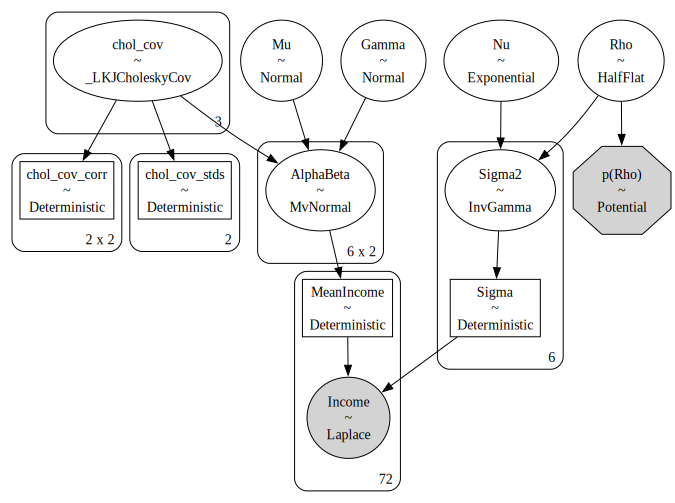

In [17]:
pm.model_to_graphviz(ModelVaryingAlphaVaryingBeta)

Get a sample from the posterior and the posterior predictive

In [18]:
with ModelVaryingAlphaVaryingBeta:
    TraceVaryingAlphaVaryingBeta = pm.sample()
    TraceVaryingAlphaVaryingBeta.extend(pm.sample_posterior_predictive(TraceVaryingAlphaVaryingBeta))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_cov, Mu, Gamma, AlphaBeta, Rho, Nu, Sigma2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 152 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [Income]


---

In [19]:
PosteriorAlpha = az.summary(
    TraceVaryingAlphaVaryingBeta.posterior.AlphaBeta[:,:,:,0]
    , kind = 'stats'
    , hdi_prob = 1-ALPHA_LEVEL
    , var_names = 'AlphaBeta'
)

PosteriorAlpha = PosteriorAlpha.rename(
    columns = {
        'mean': 'HatAlpha'
        , 'hdi_' + str((ALPHA_LEVEL/2)*100)  + '%': 'LowAlpha'
        , 'hdi_' + str((1-ALPHA_LEVEL/2)*100)  + '%': 'UppAlpha'
    }
)

In [20]:
PosteriorBeta = az.summary(
    TraceVaryingAlphaVaryingBeta.posterior.AlphaBeta[:,:,:,1]
    , kind = 'stats'
    , hdi_prob = 1-ALPHA_LEVEL
    , var_names = 'AlphaBeta'
)

PosteriorBeta = PosteriorBeta.rename(
    columns = {
        'mean': 'HatBeta'
        , 'hdi_' + str((ALPHA_LEVEL/2)*100)  + '%': 'LowBeta'
        , 'hdi_' + str((1-ALPHA_LEVEL/2)*100)  + '%': 'UppBeta'
    }
)

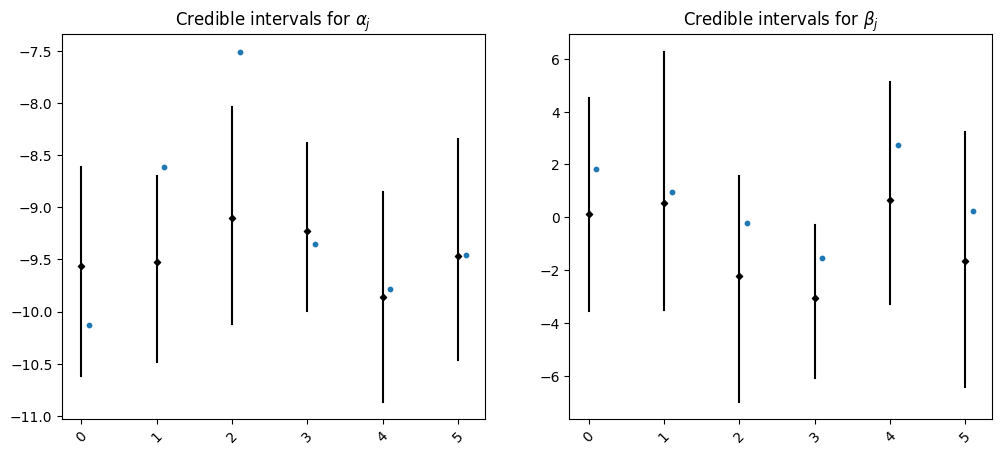

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

for k, ax in enumerate(axs.reshape(-1)):
    if k == 0:
        ax.scatter(range(J), PosteriorAlpha['HatAlpha'], marker='D', color='k', s=10)
        ax.scatter(np.arange(0.1, J+0.1, 1), ALPHA, marker='o', color='C0', s=10)

        for j in range(J):
            ax.plot(
                [j, j],
                [PosteriorAlpha['LowAlpha'][j], PosteriorAlpha['UppAlpha'][j]],
                color='k'
            )

        ax.set_title(r'Credible intervals for $\alpha_j$')
        ax.set_xticks(range(J), labels=DatRegion['Region'], rotation=45)
    else:
        ax.scatter(range(J), PosteriorBeta['HatBeta'], marker='D', color='k', s=10)
        ax.scatter(np.arange(0.1, J+0.1, 1), BETA, marker='o', color='C0', s=10)

        for j in range(J):
            ax.plot(
                [j, j],
                [PosteriorBeta['LowBeta'][j], PosteriorBeta['UppBeta'][j]],
                color='k'
            )
            
        ax.set_title(r"Credible intervals for $\beta_j$")
        ax.set_xticks(range(J), labels=DatRegion['Region'], rotation=45)

Text(0.5, 1.0, 'Posterior distribution of $\\gamma$')

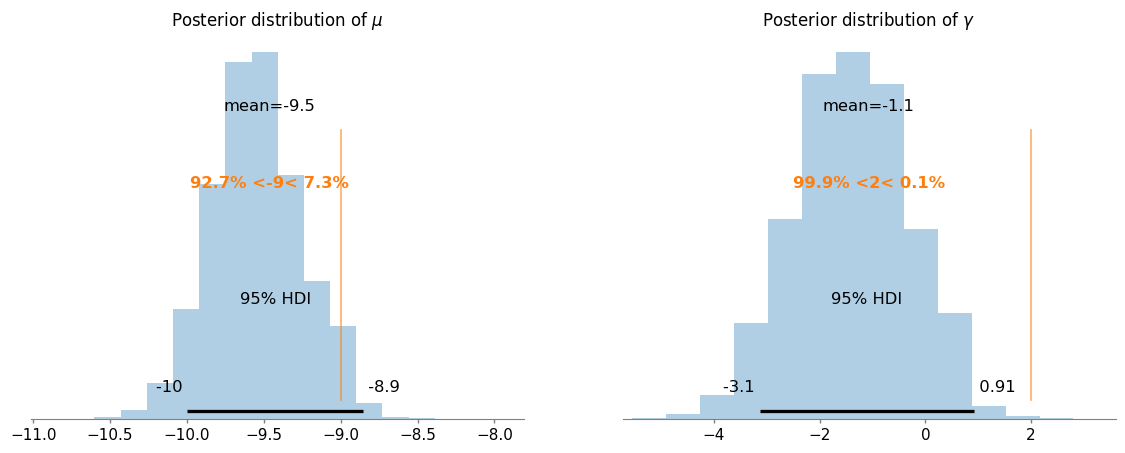

In [22]:
_, axes = plt.subplots(1,2, figsize=(14,5))

az.plot_posterior(
    TraceVaryingAlphaVaryingBeta
    , var_names = ['Mu', 'Gamma']
    , hdi_prob = 1-ALPHA_LEVEL
    , kind = 'hist'
    , textsize=11
    , ax = axes
    , ref_val = [MU, GAMMA]
)

axes[0].set_title(r"Posterior distribution of $\mu$")
axes[1].set_title(r"Posterior distribution of $\gamma$")

---

We obtain the average distribution for $\alpha, \beta$

In [23]:
MeanMuGamma = np.array(
    [float(TraceVaryingAlphaVaryingBeta.posterior.Mu.mean()), float(TraceVaryingAlphaVaryingBeta.posterior.Gamma.mean())]
)

CholModel = pm.expand_packed_triangular(
    2, TraceVaryingAlphaVaryingBeta.posterior.chol_cov.mean(dim=("chain", "draw")).values, lower=True
).eval()

SigmaAlphaBeta = np.dot(CholModel, CholModel.T)

We see how changes from separate models and complete pooling to the partial pooled model

In [24]:
AlphaCommon = TraceCommonAlphaCommonBeta.posterior.Alpha.mean(('chain', 'draw'))
BetaCommon = TraceCommonAlphaCommonBeta.posterior.Beta.mean(('chain', 'draw'))

AlphaSeparate = TraceSeparateAlphaSeparateBeta.posterior.Alpha.mean(('chain', 'draw'))
BetaSeparate = TraceSeparateAlphaSeparateBeta.posterior.Beta.mean(('chain', 'draw'))

AlphaVaryAlphaCommonBeta = TraceVaryingAlphaCommonBeta.posterior.Alpha.mean(('chain', 'draw'))
BetaVaryAlphaCommonBeta = TraceVaryingAlphaCommonBeta.posterior.Beta.mean(('chain', 'draw'))

AlphaBetaPartialPooled = TraceVaryingAlphaVaryingBeta.posterior.AlphaBeta.mean(('chain', 'draw')).T
AlphaPartialPooled = AlphaBetaPartialPooled[0]
BetaPartialPooled = AlphaBetaPartialPooled[1]

Joint distribution of $\alpha,\beta$ considering a common regression model for all the groups

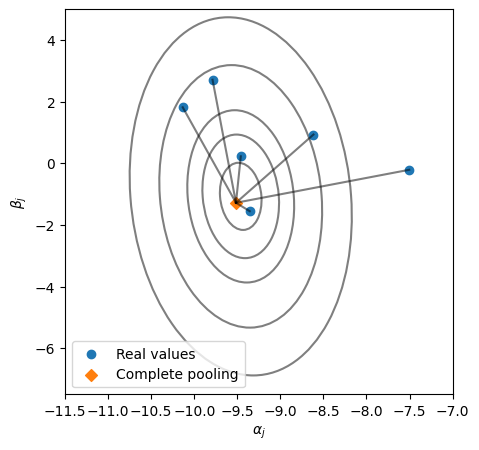

In [25]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
_ = Gauss2d(mu=MeanMuGamma, cov=np.asarray(SigmaAlphaBeta), ci=[0.1, 0.3, 0.5, 0.8, 0.95], ax=ax)

ax.scatter(ALPHA, BETA, label="Real values")
ax.scatter(AlphaCommon, BetaCommon, label="Complete pooling", marker='D')

ax.plot([[AlphaCommon]*J, ALPHA], [[BetaCommon]*J, BETA], "k-", alpha=0.5)

ax.set_xlabel(r"$\alpha_j$")
ax.set_ylabel(r"$\beta_j$")
ax.set_xlim(-11.5, -7)
ax.set_ylim(-7.5, 5)
plt.legend(loc='lower left', fontsize=10)

Joint distribution of $\alpha,\beta$ considering separate independent models for each group

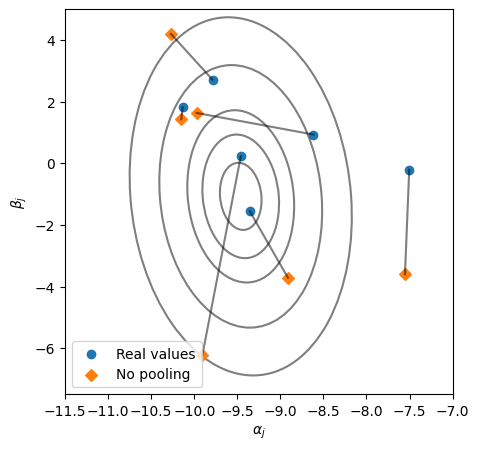

In [26]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
_ = Gauss2d(mu=MeanMuGamma, cov=np.asarray(SigmaAlphaBeta), ci=[0.1, 0.3, 0.5, 0.8, 0.95], ax=ax)

ax.scatter(ALPHA, BETA, label="Real values")
ax.scatter(AlphaSeparate, BetaSeparate, label="No pooling", marker='D')

ax.plot([AlphaSeparate, ALPHA], [BetaSeparate, BETA], "k-", alpha=0.5)

ax.set_xlabel(r"$\alpha_j$")
ax.set_ylabel(r"$\beta_j$")
ax.set_xlim(-11.5, -7)
ax.set_ylim(-7.5, 5)
plt.legend(loc='lower left', fontsize=10)

Joint distribution of $\alpha,\beta$ considering a hierarchical structure for $\alpha$ but common $\beta$

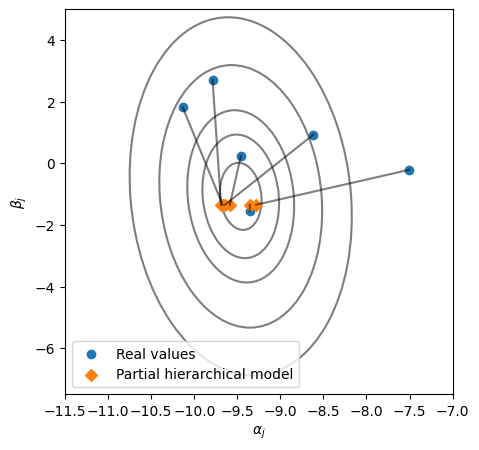

In [31]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
_ = Gauss2d(mu=MeanMuGamma, cov=np.asarray(SigmaAlphaBeta), ci=[0.1, 0.3, 0.5, 0.8, 0.95], ax=ax)

ax.scatter(ALPHA, BETA, label="Real values")
ax.scatter(AlphaVaryAlphaCommonBeta, [BetaVaryAlphaCommonBeta]*J, label="Partial hierarchical model", marker='D')

ax.plot([AlphaVaryAlphaCommonBeta, ALPHA], [[BetaVaryAlphaCommonBeta]*J, BETA], "k-", alpha=0.5)

ax.set_xlabel(r"$\alpha_j$")
ax.set_ylabel(r"$\beta_j$")
ax.set_xlim(-11.5, -7)
ax.set_ylim(-7.5, 5)
plt.legend(loc='lower left', fontsize=10)

Joint distribution of $\alpha,\beta$ considering a hierarchical structure for both $\alpha$ and $\sigma$

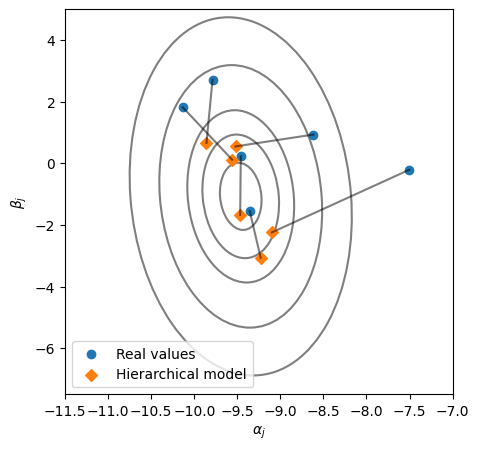

In [32]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
_ = Gauss2d(mu=MeanMuGamma, cov=np.asarray(SigmaAlphaBeta), ci=[0.1, 0.3, 0.5, 0.8, 0.95], ax=ax)

ax.scatter(ALPHA, BETA, label="Real values")
ax.scatter(AlphaPartialPooled, BetaPartialPooled, label="Hierarchical model", marker='D')

ax.plot([AlphaPartialPooled, ALPHA], [BetaPartialPooled, BETA], "k-", alpha=0.5)

ax.set_xlabel(r"$\alpha_j$")
ax.set_ylabel(r"$\beta_j$")
ax.set_xlim(-11.5, -7)
ax.set_ylim(-7.5, 5)
plt.legend(loc='lower left', fontsize=10)

---

Scatterplot

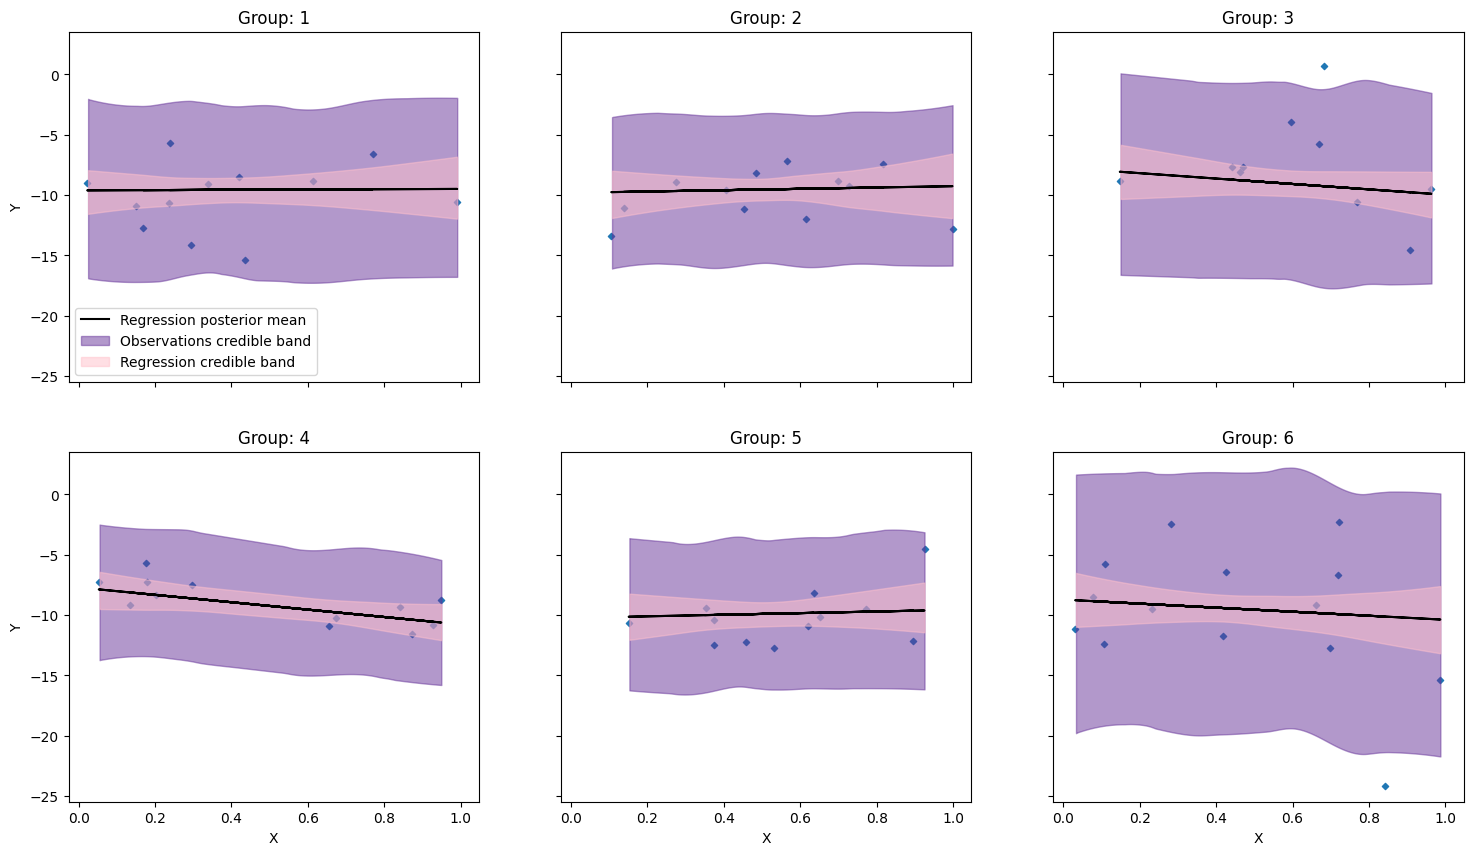

In [34]:
fig, axs = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(18,10))

for k, ax in enumerate(axs.reshape(-1)):
    Aux = Dat[Dat['Region']==k]

    ax.scatter(
        Aux[PREDICTOR]
        , Aux[VARIABLE]
        , marker = 'D'
        , s = 10
    )

    ax.plot(
        Aux[PREDICTOR]
        , TraceVaryingAlphaVaryingBeta.posterior.MeanIncome[:,:,Aux.index].mean(('chain', 'draw'))
        , label="Regression posterior mean"
        , color='k'
    )

    az.plot_hdi(
        Aux[PREDICTOR]
        , TraceVaryingAlphaVaryingBeta.posterior_predictive.Income[:,:,Aux.index]
        , hdi_prob=1-ALPHA_LEVEL
        , color='rebeccapurple'
        , fill_kwargs={'alpha': 0.5, 'label':"Observations credible band"}
        , ax = ax
    )

    az.plot_hdi(
        Aux[PREDICTOR]
        , TraceVaryingAlphaVaryingBeta.posterior.MeanIncome[:,:,Aux.index]
        , hdi_prob=1-ALPHA_LEVEL
        , color='pink'
        , fill_kwargs={'alpha': 0.5, 'label':"Regression credible band"}
        , ax = ax
    )

    ax.set_title('Group: ' + str(k+1))

    if k in [0,3]:
        ax.set_ylabel(VARIABLE)
        
        if k == 0:
            ax.legend()

    if k in [3,4,5]:
        ax.set_xlabel(PREDICTOR)

---

Comparing the models

In [35]:
pm.compute_log_likelihood(TraceCommonAlphaCommonBeta, model = ModelCommonAlphaCommonBeta)
pm.compute_log_likelihood(TraceSeparateAlphaSeparateBeta, model = ModelSeparateAlphaSeparateBeta)
pm.compute_log_likelihood(TraceVaryingAlphaCommonBeta, model = ModelVaryingAlphaCommonBeta)
pm.compute_log_likelihood(TraceVaryingAlphaVaryingBeta, model = ModelVaryingAlphaVaryingBeta)

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [38]:
CompareTable = az.compare(
    {
        "National Model": TraceCommonAlphaCommonBeta
        , "Separate Model": TraceSeparateAlphaSeparateBeta
        , "Varying Intercept, Same Slope": TraceVaryingAlphaCommonBeta
        , "Varying Intercept, Varying Slope": TraceVaryingAlphaVaryingBeta
    }
    , ic = COMPARE_METRIC
    , scale = 'deviance'
)

In [ ]:
CompareTable.round(2)

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
"Varying Intercept, Varying Slope",0,1354.28,14.32,0.00,0.29,16.15,0.00,True,deviance
"Varying Intercept, Same Slope",1,1354.69,10.89,0.41,0.49,17.46,5.60,True,deviance
Separate Model,2,1359.18,15.13,4.90,0.22,13.08,8.49,True,deviance
National Model,3,1387.05,4.06,32.77,0.00,18.30,11.97,True,deviance


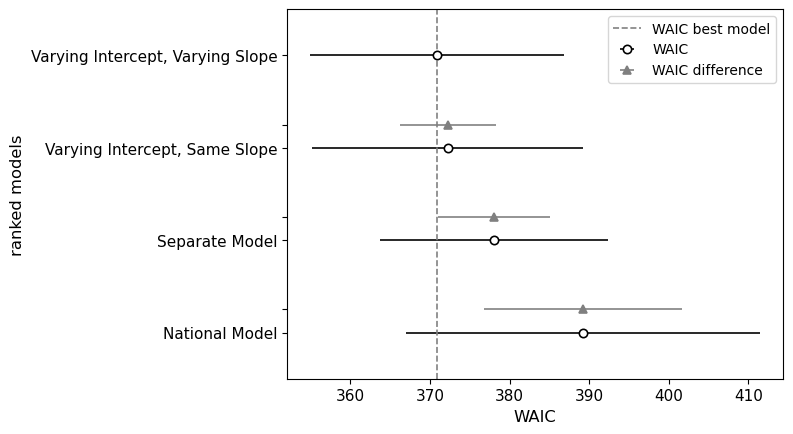

In [39]:
_, axes = plt.subplots(1,1)

az.plot_compare(
    CompareTable
    , textsize = 11
    , figsize = (10,5)
    , ax = axes
    , title =  False
    )

axes.set_xlabel(str.upper(COMPARE_METRIC))
axes.legend([str.upper(COMPARE_METRIC) + " best model", str.upper(COMPARE_METRIC), str.upper(COMPARE_METRIC) + ' difference'])